## 1. IMPORT LIBRARY & LOAD DATA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from textblob import TextBlob

# Membaca file dataset
df = pd.read_csv('dataset_tiktok-comments-scraper_2025-12-09_02-52-00-697.csv')

print("5 Data Teratas:")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
print(df[['uniqueId', 'text']].head())

5 Data Teratas:
       uniqueId                                    text
0   shelaacitra   In enginerring we trust issue ya kak🙏
1        bmstrr     Wadoww, geser ke teknik mesin kak🙏🏼
2     _nofamous                      engineer boys lek😎
3        bmstrr                             Jelas lekkk
4  bestiee_udin  wong pkl mek turu gaya engineering boy


## 2. DATA UNDERSTANDING


Jumlah Baris Data: 879
Rata-rata Panjang Komentar: 26.84 karakter
Jumlah Komentar Duplikat: 65
Jumlah Data Kosong di kolom text: 2


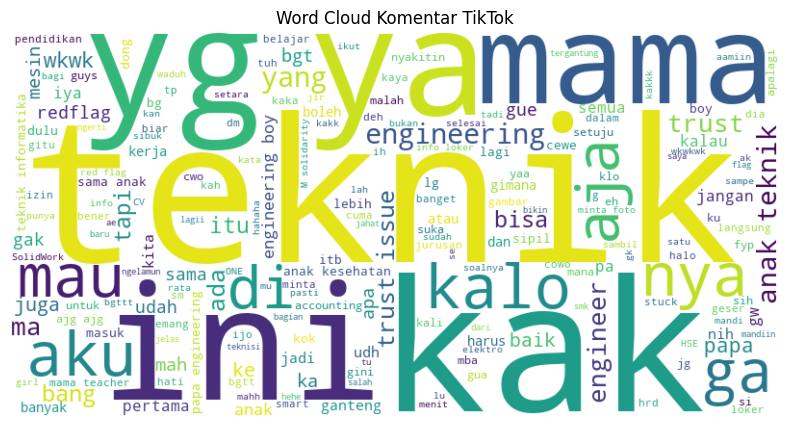

In [ ]:

# 1. Jumlah baris data
print(f"\nJumlah Baris Data: {len(df)}")

# 2. Panjang rata-rata setiap baris (jumlah karakter)
df['text_length'] = df['text'].astype(str).apply(len)
print(f"Rata-rata Panjang Komentar: {df['text_length'].mean():.2f} karakter")

# 3. Cek data duplikasi pada kolom 'text'
duplikasi = df.duplicated(subset=['text']).sum()
print(f"Jumlah Komentar Duplikat: {duplikasi}")

# 4. Cek data kosong
null_data = df['text'].isnull().sum()
print(f"Jumlah Data Kosong di kolom text: {null_data}")

# Membersihkan data kosong dan duplikat untuk analisis selanjutnya
df_clean = df.drop_duplicates(subset=['text']).dropna(subset=['text']).copy()

# 5. Distribusi data menggunakan Word Cloud
all_text = " ".join(review for review in df_clean.text.astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Komentar TikTok')
plt.show()

## 3. DATA TEXT PROCESSING (UPDATED)

In [ ]:
# ==========================================
# 3. DATA TEXT PROCESSING (UPDATED)
# ==========================================

positive_words = [
    "ganteng", "pinter", "semangat", "keren", "idaman", "trust", "love", "suka", "sayang", "baikk",
    "joss", "mantap", "aamiin", "sukses", "best", "bagus", "menarik", "sehat", "bahagia", "top",
    "tier", "aman", "jaya", "menyala", "gas", "sikat", "masya allah", "subhanallah", "alhamdulillah",
    "smart", "bijak", "lucu", "ngakak", "wkwk", "haha", "hebat", "pro", "suhu", "terbaik", "idola",
    "senyum", "ketawa", "kocak", "menghibur", "seru", "asik", "enak", "nyaman", "adem", "tenang",
    "damai", "rindu", "kangen", "cinta", "beauty", "cantik", "manis", "imut", "cute", "wow", "kerenn", "bismillah", "greenflag"
]

negative_words = [
    "takut", "buaya", "redflag", "jahat", "toxic", "sampah", "jelek", "benci", "marah", "kesel",
    "kecewa", "bosen", "capek", "lelah", "pusing", "bingung", "susah", "sulit", "ribet", "mahal",
    "rugi", "bohong", "palsu", "curang", "anjing", "babi", "bangsat", "goblok", "tolol", "bodoh",
    "gila", "setan", "sakit", "sedih", "nangis", "kecewa", "hancur", "rusak", "parah", "buruk",
    "stress", "stres", "gagal", "kalah", "batal", "tumbang", "trauma", "hindari", "jangan", "run", "kabur"
]

# --- 2. Fungsi Pembersih Teks ---
def clean_text(text):
    text = str(text).lower()                  
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan fungsi cleaning ke data
df_clean['cleaned_text'] = df_clean['text'].apply(clean_text)

# --- 3. Fungsi Labeling Hybrid (Keyword + TextBlob) ---
def get_sentiment(text):
    # Pastikan text string
    text_clean = clean_text(str(text))
    words = text_clean.split()
    
    # Cek kecocokan dengan kata kunci Positif/Negatif terlebih dahulu
    for word in positive_words:
        if word in words:
            return "Positif"
    for word in negative_words:
        if word in words:
            return "Negatif"
            
    analysis = TextBlob(str(text))
    if analysis.sentiment.polarity > 0.05:
        return "Positif"
    elif analysis.sentiment.polarity < -0.05:
        return "Negatif"
    else:
        return "Netral"

# Terapkan labeling
print("Sedang melakukan pelabelan data...")
df_clean['label'] = df_clean['cleaned_text'].apply(get_sentiment)

print("\nContoh Hasil Processing & Labeling Baru:")
print(df_clean[['cleaned_text', 'label']].head())

# Cek Distribusi Label Baru
print("\nDistribusi Label:")
print(df_clean['label'].value_counts())

# --- 4. Text Vektorisasi (TF-IDF) ---
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df_clean['cleaned_text'])
y = df_clean['label']

# --- 5. Data Splitting ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nJumlah Data Latih: {X_train.shape[0]}")
print(f"Jumlah Data Uji: {X_test.shape[0]}")

Sedang melakukan pelabelan data...

Contoh Hasil Processing & Labeling Baru:
                             cleaned_text    label
0    in enginerring we trust issue ya kak  Positif
1        wadoww geser ke teknik mesin kak   Netral
2                       engineer boys lek   Netral
3                             jelas lekkk   Netral
4  wong pkl mek turu gaya engineering boy   Netral

Distribusi Label:
label
Netral     645
Positif    126
Negatif     42
Name: count, dtype: int64

Jumlah Data Latih: 650
Jumlah Data Uji: 163


## 4. TEXT VEKTORISASI & DATA SPLITTING (UPDATED)

In [11]:
# ==========================================
# 4. TEXT VEKTORISASI & DATA SPLITTING (UPDATED)
# ==========================================

# --- Text Vektorisasi (TF-IDF) ---
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X = tfidf.fit_transform(df_clean['cleaned_text'])
y = df_clean['label']

# --- Data Splitting ---
# Membagi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- OVERSAMPLING MANUAL (PENTING) ---
from sklearn.utils import resample

# Gabungkan X_train dan y_train sementara untuk proses resampling
train_data = pd.DataFrame(X_train.toarray(), columns=tfidf.get_feature_names_out())
train_data['label'] = y_train.values

# Pisahkan berdasarkan kelas
df_netral = train_data[train_data['label'] == 'Netral']
df_positif = train_data[train_data['label'] == 'Positif']
df_negatif = train_data[train_data['label'] == 'Negatif']

# Oversample minoritas (Positif)
n_samples = len(df_netral) # Target jumlah sampel (samakan dengan Netral)

if not df_positif.empty and n_samples > 0:
    df_positif_os = resample(df_positif, replace=True, n_samples=n_samples, random_state=42)
else:
    df_positif_os = df_positif

# Oversample minoritas (Negatif)
if not df_negatif.empty and n_samples > 0:
    df_negatif_os = resample(df_negatif, replace=True, n_samples=n_samples, random_state=42)
else:
    df_negatif_os = df_negatif

# Gabungkan kembali data yang sudah seimbang
df_train_balanced = pd.concat([df_netral, df_positif_os, df_negatif_os])

# Pisahkan X dan y lagi untuk training
X_train_balanced = df_train_balanced.drop('label', axis=1).values
y_train_balanced = df_train_balanced['label']

print(f'\nJumlah Data Latih (Setelah Balancing): {X_train_balanced.shape[0]}')
print(f'Jumlah Data Uji: {X_test.shape[0]}')


Jumlah Data Latih (Setelah Balancing): 1533
Jumlah Data Uji: 163


## DATA MODELING & COMPARISON

In [ ]:
# ==========================================
# 5. DATA MODELING & COMPARISON
# ==========================================

# 1. Naive Bayes
print("Training Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)
y_pred_nb = nb_model.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

# 2. Logistic Regression (Model pada App)
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)
y_pred_lr = lr_model.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

# --- PERBANDINGAN ---
print(f"\nAkurasi Naive Bayes: {acc_nb:.4f}")
print(f"Akurasi Logistic Regression: {acc_lr:.4f}")

if acc_lr > acc_nb:
    print("\nKESIMPULAN: Logistic Regression lebih akurat.")
else:
    print("\nKESIMPULAN: Naive Bayes lebih akurat atau sama.")

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

Training Naive Bayes...
Training Logistic Regression...



Akurasi Naive Bayes: 0.6442
Akurasi Logistic Regression: 0.8834

KESIMPULAN: Logistic Regression lebih akurat.

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

     Negatif       0.33      0.17      0.22         6
      Netral       0.89      0.98      0.93       134
     Positif       0.92      0.52      0.67        23

    accuracy                           0.88       163
   macro avg       0.72      0.56      0.61       163
weighted avg       0.88      0.88      0.87       163



## 6. DATA PREDIKSI (DATA BARU)

In [13]:
# ==========================================
# 6. DATA PREDIKSI (DATA BARU)
# ==========================================

# Data baru yang ingin dicek
input_baru = [
    "Teknik mesin keren banget parah",
    "Gak suka videonya jelek",
    "Biasa aja sih menurutku"
]

# Bersihkan data baru
input_bersih = [clean_text(i) for i in input_baru]

# Vektorisasi data baru (gunakan tfidf yang SUDAH dilatih, jangan fit baru)
input_vec = tfidf.transform(input_bersih)

# Prediksi
hasil_prediksi = lr_model.predict(input_vec)

print("\nHasil Prediksi pada Data Baru:")
for teks, hasil in zip(input_baru, hasil_prediksi):
    print(f"Komentar: '{teks}' -> Sentimen: {hasil}")


Hasil Prediksi pada Data Baru:
Komentar: 'Teknik mesin keren banget parah' -> Sentimen: Positif
Komentar: 'Gak suka videonya jelek' -> Sentimen: Positif
Komentar: 'Biasa aja sih menurutku' -> Sentimen: Netral
